In [20]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import scipy.stats as sps
from time import perf_counter, sleep
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [10,7]


On considère un processus stochastique en dimension 1 :
$$dX(t)=-V'(X(t)) dt + \sqrt{2 \varepsilon}\ dB(t)$$
où $V:\mathbb R \to \mathbb R$ est une fonction potentielle, $\varepsilon >0$ fixe l'intensité du bruit et $(B(t))_{t \ge 0}$ est un mouvement brownien standard. Pour deux réels $a<b$, on note $\tau_a= \inf\{t \ge 0, X(t)<a\}$ et  $\tau_b= \inf\{t \ge 0, X(t)>b\}$. Pour une condition initiale $X(0)=x_0 \in (a,b)$ fixée, on souhaite évaluer
$$p=\mathbb P(\tau_b < \tau_a)$$
dans le cas où cette probabilité est très petite.

On introduit un pas de temps $\delta_t>0$ et la discrétisation suivante : pour tout $k \ge 0$,
$$X_{k+1} = X_k - V'(X_k) \delta_t + \sqrt{2 \varepsilon \delta_t}\ G_k$$
où $(G_k)_{k \ge 0}$ est une suite i.i.d. de gaussiennes centrées réduites. On considère donc des trajectoires $(X_k)_{0 \le k \le T_a \wedge T_b}$ où $T_a=\min\{k\ge 0, \, X_k < a\}$ et $T_b=\min\{k\ge 0, \, X_k > b\}$.

#### Question 2.0 #### 
Représenter la fonction potentielle $V(x)=\frac{x^4}{4}-\frac{x^2}{2}+\frac{x^3}{3}$ sur l'intervalle $[-1.5;1.5]$.

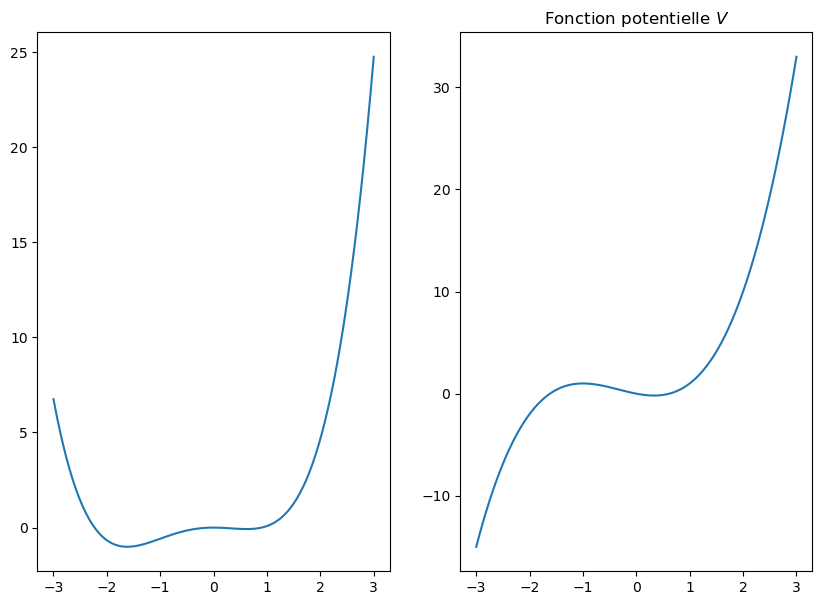

In [12]:
V= lambda x : x**4/4-x**2/2+x**3/3
Vprime= lambda x :x**3-x+x**2
     

x = np.linspace(-3, 3, num=100)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, V(x))
ax2.plot(x, Vprime(x))
plt.title("Fonction potentielle $V$");

In [13]:
from scipy.optimize import minimize_scalar

def V(x):
    return (x**4)/4 - (x**2)/2 + (x**3)/3

extremas = [(res_min.x, V(res_min.x)) for i in range(1,3) for res_min in [minimize_scalar(V, bounds=(-3+i, -3+i+1), method='bounded')]]


In [14]:
(x1,_),(x2,_)=extremas

In [15]:
x2

-0.9999940391390134

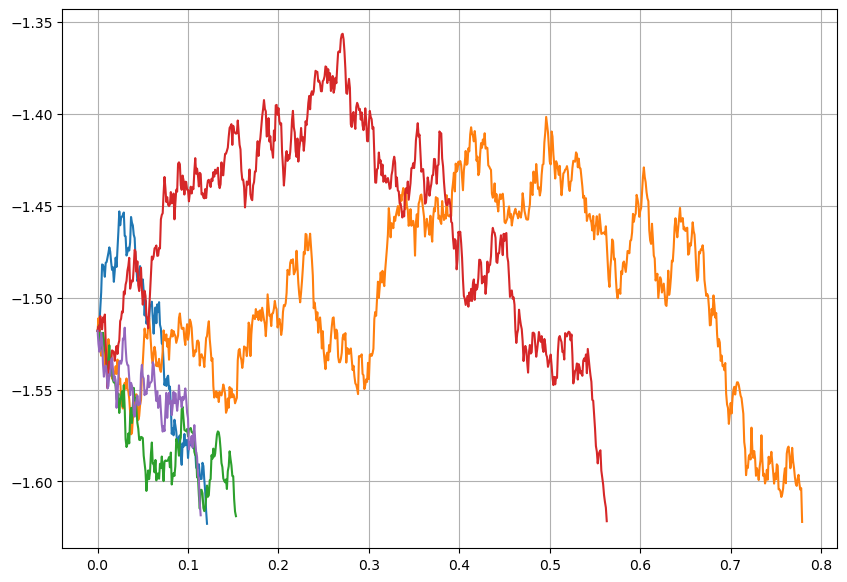

In [16]:
a = x1
b = x2
x0 = x1+0.1
epsilon = 0.02
dt = 0.001
sigma = np.sqrt(2*epsilon*dt)

# Simulation d'une trajectoire



def sim_traj(a, b, x0, epsilon, dt):
    X = [x0]
    sigma = np.sqrt(2 * epsilon * dt)
    while X[-1] >= a and X[-1] <= b:
        X.append(X[-1] - Vprime(X[-1]) * dt + sigma * sps.norm.rvs())
    X = np.asarray(X)
    return X

def plot_X(traj):
    l = len(traj)
    temps = np.arange(l)*dt
    plt.plot(temps,traj)
    plt.grid()
for _ in range(5):
    plot_X(sim_traj(a,b,x0,epsilon,dt))

plt.show()
    
# Xmax = X.max()
# print(f"Maximum de la trajectoire : {Xmax:1.3f}")

Durée (s) : 70.9
Estimation de la probabilité : 1.61e-01
Intervalle de confiance asymptotique : [1.58e-01,1.63e-01]


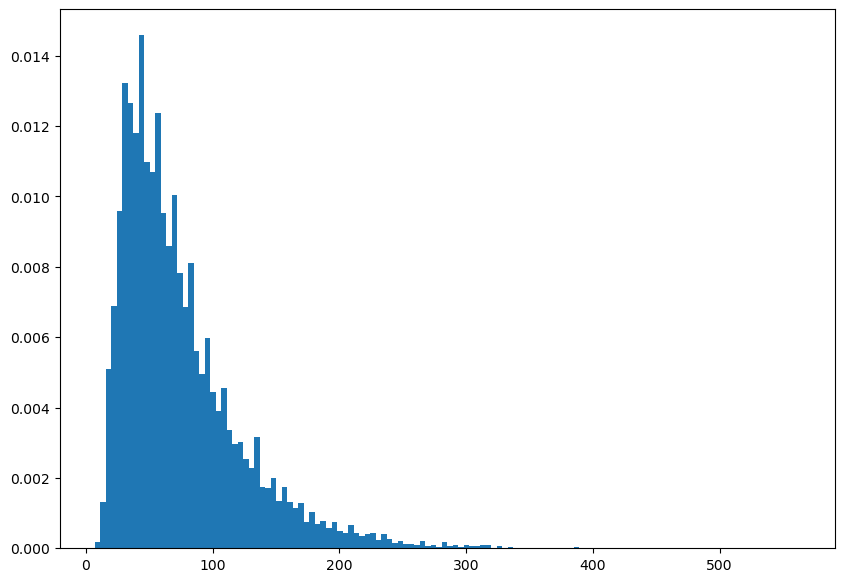

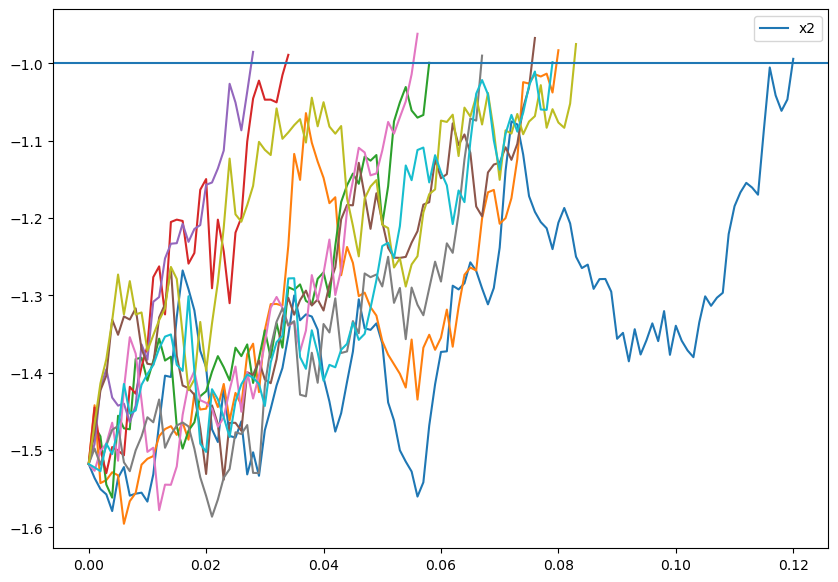

In [17]:
epsilon = 1
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 100000

t0 = perf_counter()
compteur = 0
lengths =[]
trajs=[]
for i in range(n):
    temp=[x0]
    X = x0
    while a <= X <= b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
        temp.append(X)
    if X>b:
        compteur += 1
        lengths.append(len(temp))
        trajs.append(temp)
        temp=[x0]
        
phat = compteur/n
rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
borneinf = phat-rayon
bornesup = phat+rayon

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Estimation de la probabilité : {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

duree = np.zeros(n)
c = np.log(0.89*0.9)-0.5*np.log(1-0.89**2)-0.5*np.log(1-0.9**2)

for i in range(n):
    duree[i]=lengths[i]*dt

kde = sps.gaussian_kde(duree)
t = np.linspace(-3-np.log(epsilon)+c, 6-np.log(epsilon)+c, num=100)

plt.plot(t,sps.gumbel_r.pdf(t+np.log(epsilon)-c), label=r"$-\log\varepsilon+G+c$")
plt.plot(t, kde(t), color="black", label="kde")
plt.legend();

plt.hist(lengths,bins='auto',density=True, label="histogramme")
plt.show()
for _ in range(10):
    plot_X(trajs[_])
plt.axhline(y=x2,label="x2")
plt.legend();


Durée (s) : 426.2
Estimation de la probabilité : 1.45e-02
Intervalle de confiance asymptotique : [1.37e-02,1.52e-02]


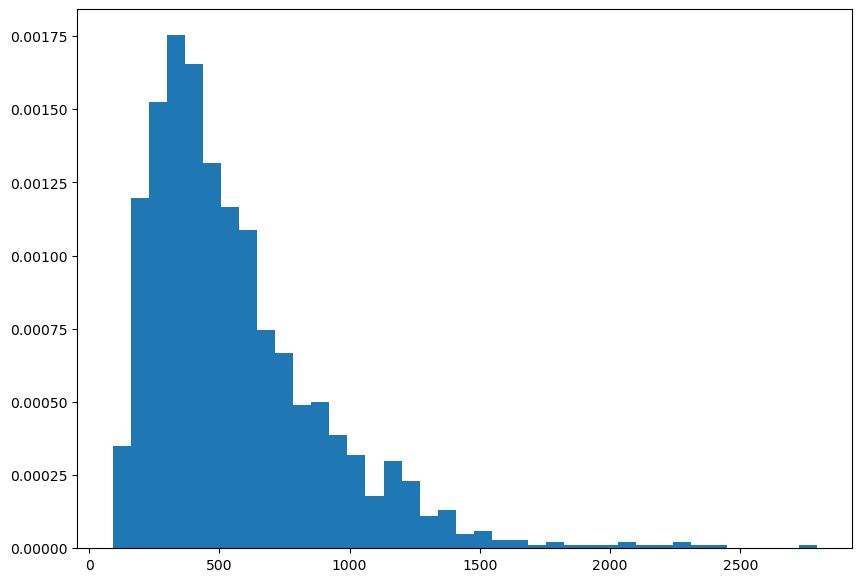

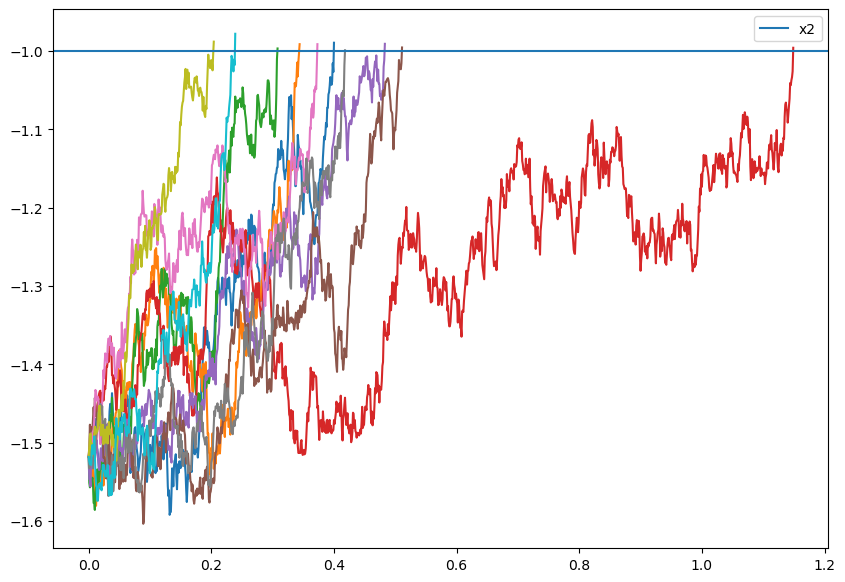

In [18]:
epsilon = 0.1
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 100000

t0 = perf_counter()
compteur = 0
lengths =[]
trajs=[]
for i in range(n):
    temp=[x0]
    X = x0
    while X>=a and X<=b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
        temp.append(X)
    if X>b:
        compteur += 1
        lengths.append(len(temp))
        trajs.append(temp)
        temp=[x0]
        
phat = compteur/n
rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
borneinf = phat-rayon
bornesup = phat+rayon

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Estimation de la probabilité : {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")



plt.hist(lengths,bins='auto',density=True, label="histogramme")
plt.show()
for _ in range(min(len(trajs),10)):
    plot_X(trajs[_])
plt.axhline(y=x2,label="x2")
plt.legend();
plt.show()

In [22]:
epsilon = 0.01
alpha = 0.05
sigma = np.sqrt(2*epsilon*dt)
n = 10000

t0 = perf_counter()
compteur = 0
lengths =[]
trajs=[]
for i in tqdm(range(n)):
    temp=[x0]
    X = x0
    while X>=a and X<=b:
        X = X-Vprime(X)*dt+sigma*sps.norm.rvs()
        temp.append(X)
    if X>b:
        compteur += 1
        lengths.append(len(temp))
        trajs.append(temp)
        temp=[x0]
        
phat = compteur/n
rayon = sps.norm.ppf(1-alpha/2)*np.sqrt(phat*(1-phat)/n)
borneinf = phat-rayon
bornesup = phat+rayon

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"Estimation de la probabilité : {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")


if len(trajs)>0:
    plt.hist(lengths,bins='auto',density=True, label="histogramme")
    plt.show()
    for _ in range(10):
        plot_X(trajs[_])
    plt.axhline(y=x2,label="x2")
    plt.legend();
    plt.show()
else : print("no reactive trajectory found ):")

100%|██████████| 10000/10000 [01:43<00:00, 96.50it/s]

Durée (s) : 103.6
Estimation de la probabilité : 0.00e+00
Intervalle de confiance asymptotique : [0.00e+00,0.00e+00]
no reactive trajectory found ):


**AMS**

100%|██████████| 10/10 [00:00<00:00, 90.36it/s]


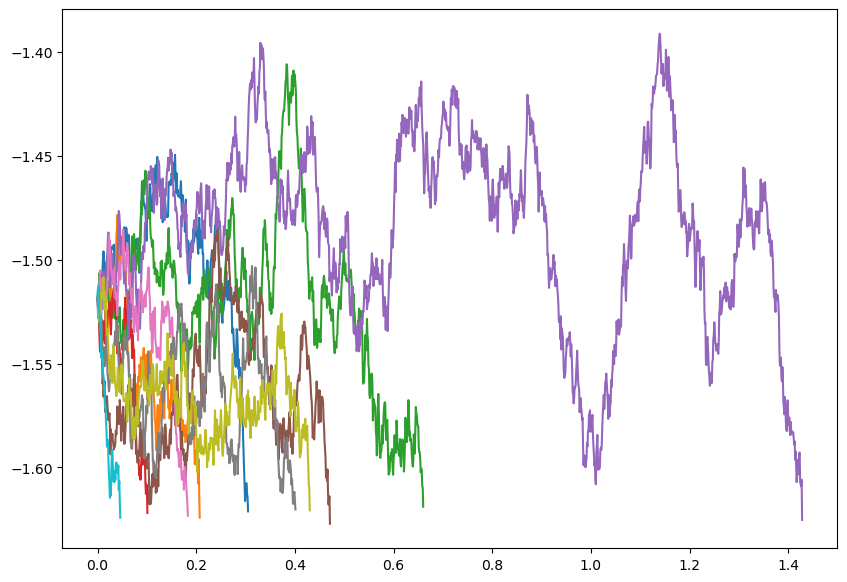

In [23]:
epsilon = 0.02
n = 10
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
p = 1

for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.array(X)
    X_AMS.append(X)

# Calcul des maxima
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
p *= (1-K.size/n)
    
# Affichage
for i in range(n):
    # sleep(.5)
    plot_X(X_AMS[i]) 

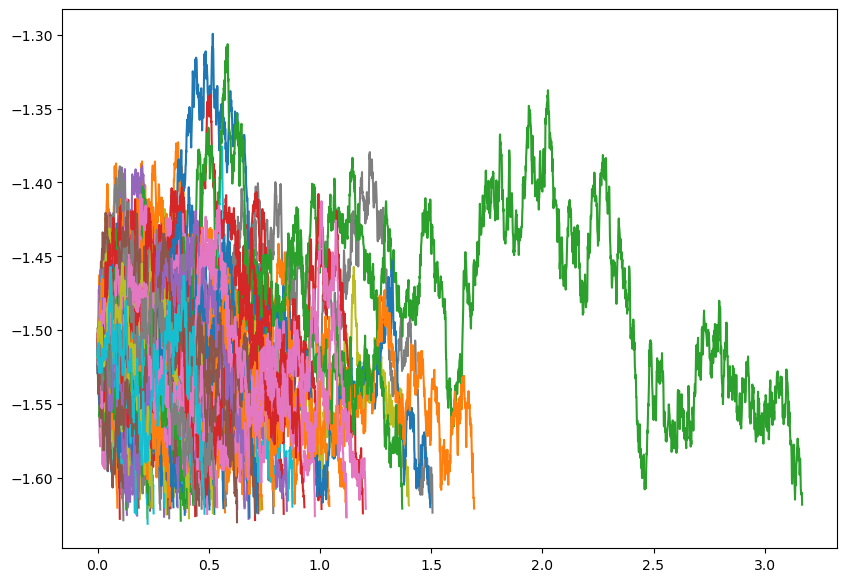

niveau= -1.4781170759438915


KeyboardInterrupt: 

In [24]:
epsilon = 0.02
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in tqdm(range(n)):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("K =",K)
    phat *= (1-K.size/n)
    # Affichage
    clear_output(wait=True)
    # sleep(.1)
    for i in range(n):
        plot_X(X_AMS[i])
    plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

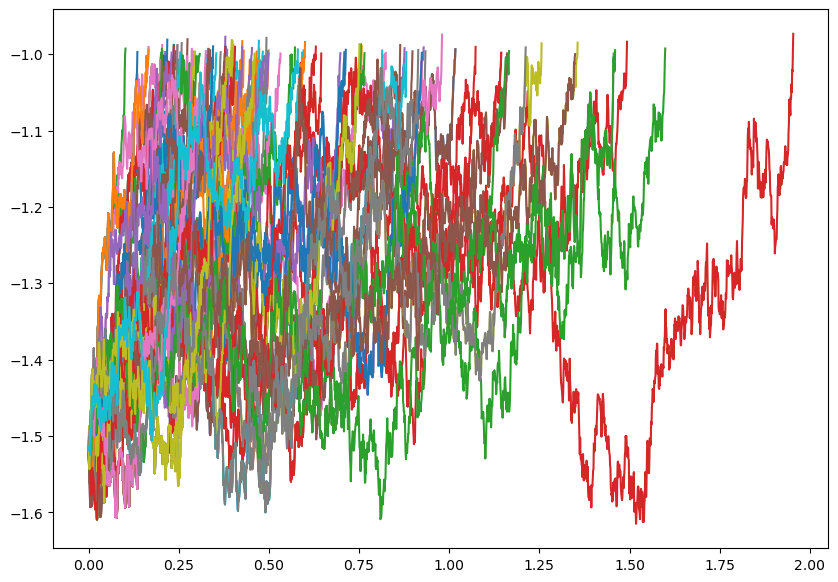

Durée (s) : 124.7
L'estimation de la probabilité est 1.34e-02
Intervalle de confiance asymptotique : [7.93e-03,1.88e-02]


In [12]:
epsilon = 0.1
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    #print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("K =",K)
    phat *= (1-K.size/n)
    # Affichage
    clear_output(wait=True)
    # sleep(.1)
    for i in range(n):
        plot_X(X_AMS[i])
    plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

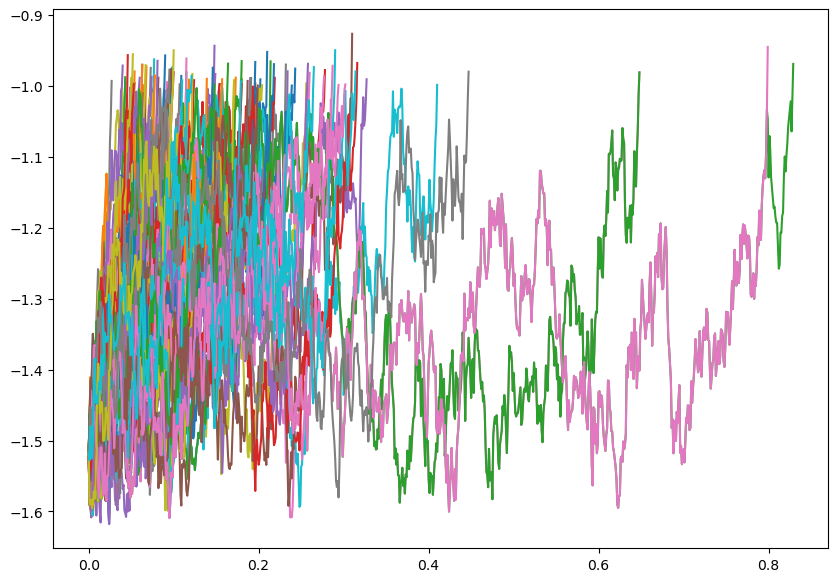

Durée (s) : 48.2
L'estimation de la probabilité est 1.08e-01
Intervalle de confiance asymptotique : [7.66e-02,1.40e-01]


In [13]:
epsilon = 0.5
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    #print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("K =",K)
    phat *= (1-K.size/n)
    # Affichage
    clear_output(wait=True)
    # sleep(.1)
    for i in range(n):
        plot_X(X_AMS[i])
    plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")

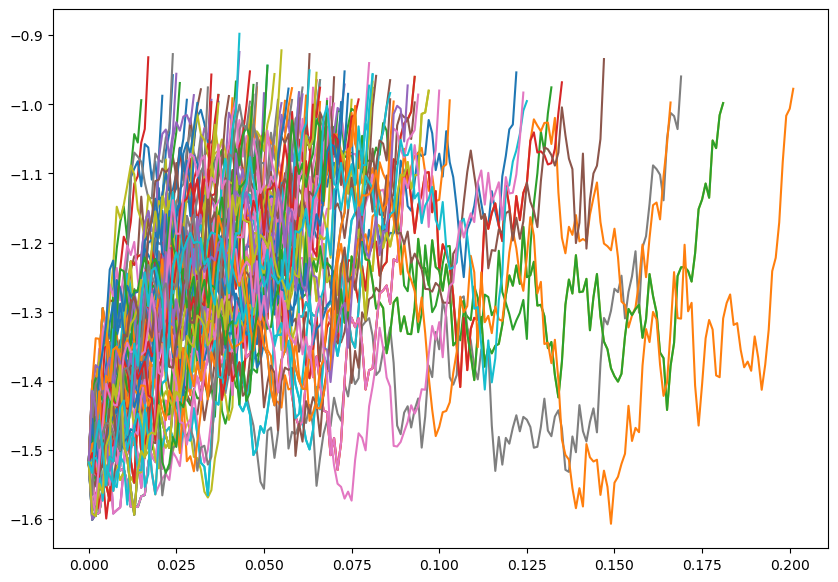

Durée (s) : 30.8
L'estimation de la probabilité est 1.91e-01
Intervalle de confiance asymptotique : [1.43e-01,2.39e-01]


In [14]:
epsilon = 1
n = 100
sigma = np.sqrt(2*epsilon*dt)

X_AMS = []
phat = 1
t0 = perf_counter()

lengths=[]
for i in range(n):
    X = [x0]
    while X[-1]>=a and X[-1]<=b:
        X.append(X[-1]-Vprime(X[-1])*dt+sigma*sps.norm.rvs())
    X = np.asarray(X)
    if X[-1]>b: lengths.append(len(X))
    X_AMS.append(X)
S = np.zeros(n)
for i in range(n):
    S[i] = max(X_AMS[i])

L = np.min(S)   
K = np.argwhere(S==L).ravel()
phat *= (1-K.size/n)

while(L<=b):
    #print("niveau=",L)
    # Procédure de rééchantillonnage
    for i in K:
        Iprime = np.random.choice([i for i in range(n) if i not in K])
        n0 = np.argmax(X_AMS[Iprime]>L) # 1er temps où X dépasse L
        X_AMS[i] = list(X_AMS[Iprime][:n0+1])    
        while X_AMS[i][-1]>=a and X_AMS[i][-1]<=b:
            X_AMS[i].append(X_AMS[i][-1]-Vprime(X_AMS[i][-1])*dt+sigma*sps.norm.rvs())
        X_AMS[i] = np.array(X_AMS[i])
        S[i] = max(X_AMS[i])
    L = np.min(S)   
    K = np.argwhere(S==L).ravel()
    #print("K =",K)
    phat *= (1-K.size/n)
    # Affichage
    clear_output(wait=True)
    # sleep(.1)
    for i in range(n):
        plot_X(X_AMS[i])
    plt.show()
    
sigmahat = np.sqrt(-phat**2*np.log(phat)/n) 
alpha = 0.05
borneinf = phat - sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)
bornesup = phat + sps.norm.ppf(1-alpha/2)*phat*np.sqrt(-np.log(phat))/np.sqrt(n)

print(f"Durée (s) : {perf_counter()-t0:1.1f}")
print(f"L'estimation de la probabilité est {phat:1.2e}")
print(f"Intervalle de confiance asymptotique : [{borneinf:1.2e},{bornesup:1.2e}]")